## Imports

In [25]:
pip install pyccel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

from sympy import init_printing
init_printing(use_latex=True)

## Pure python function

In [27]:
def solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu):
    for n in range(nt):
      u[0] = un[0] - un[0] * dt / dx * (un[0] - un[-2]) + nu * dt / dx**2 *\
                    (un[1] - 2 * un[0] + un[-2])
      u[-1] = u[0]
      for i in range(nx): un[i] = u[i]
      for i in range(1, nx-1):
        u[i] = un[i] - un[i] * dt / dx *(un[i] - un[i-1]) + nu * dt / dx**2 *\
                    (un[i+1] - 2 * un[i] + un[i-1])
        
    return 0

## Numba accelerator

In [28]:
@njit(fastmath=True)
def solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu):
    
    for n in range(nt):
      u[0] = un[0] - un[0] * dt / dx * (un[0] - un[-2]) + nu * dt / dx**2 *\
                    (un[1] - 2 * un[0] + un[-2])
      u[-1] = u[0]
      for i in range(nx): un[i] = u[i]
      for i in range(1, nx-1):
            u[i] = un[i] - un[i] * dt / dx *(un[i] - un[i-1]) + nu * dt / dx**2 *\
                    (un[i+1] - 2 * un[i] + un[i-1])
        
    return 0

## Pyccel accelerator

In [29]:
@types('float[:]','float[:]', 'int', 'int', 'float', 'float', 'float')
def solve_1d_burger_pyccel(u, un, nt, nx, dt, dx, nu):
    
    for n in range(nt):
      u[0] = un[0] - un[0] * dt / dx * (un[0] - un[-2]) + nu * dt / dx**2 *\
                    (un[1] - 2 * un[0] + un[-2])
      u[-1] = u[0]
      for i in range(nx): un[i] = u[i]
      for i in range(1, nx-1):
            u[i] = un[i] - un[i] * dt / dx *(un[i] - un[i-1]) + nu * dt / dx**2 *\
                    (un[i+1] - 2 * un[i] + un[i-1])
        
        
        
    return 0

## Inputs

In [30]:
x, nu, t = sp.symbols('x nu t')
phi = (sp.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sp.exp(-(x - 4 * t - 2 * sp.pi)**2 / (4 * nu * (t + 1))))

phiprime = phi.diff(x)
u = -2 * nu * (phiprime / phi) + 4
ufunc = lambdify((t, x, nu), u)

###variable declarations
nx = 201
nt = 100
dx = 2 * np.pi / (nx - 1)
nu = .07
dt = dx * nu

x = np.linspace(0, 2 * np.pi, nx)
un = np.empty(nx)
t = 0

## Plot initial condition

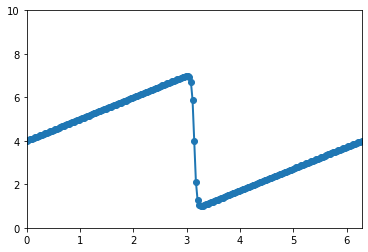

In [31]:
u = np.asarray([ufunc(t, x0, nu) for x0 in x])
plt.figure()
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10]);

# Analytical solution
u_analytical = np.asarray([ufunc(nt * dt, xi, nu) for xi in x])

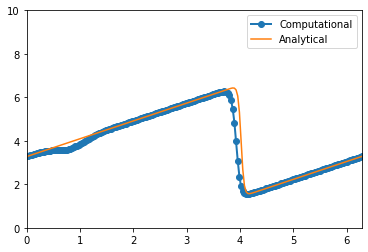

In [32]:
solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)
#Plotting data
plt.figure()
plt.plot(x,u, marker='o', lw=2, label='Computational')
plt.plot(x, u_analytical, label='Analytical')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10])
plt.legend();

## Call Funtions

### Pure function

In [33]:
%timeit solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

10 loops, best of 5: 42 ms per loop


### Function with numba accelerator

In [34]:
%timeit solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu)

The slowest run took 26927.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 13 µs per loop


### Function with pyccel accelerator

In [35]:
solve_1d_burger_f90 = epyccel(solve_1d_burger_pyccel)
%timeit solve_1d_burger_f90(u, un, nt, nx, dt, dx, nu)

10000 loops, best of 5: 37.8 µs per loop
